In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from scandataset import SCANDataset
from transformer import Transformer
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from hyperparam_config.hyperparam_exp1 import *

In [2]:
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

device

'mps'

In [3]:
MAX_LEN = 50

src_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'walk',
    'look',
    'run',
    'jump',
    'turn',
    'left',
    'right',
    'and',
    'after',
    'opposite',
    'twice',
    'thrice',
    'around',
]

tgt_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'I_WALK',
    'I_RUN',
    'I_JUMP',
    'I_LOOK',
    'I_TURN_RIGHT',
    'I_TURN_LEFT'
]

def list_to_dict(lst):
    return {k: v for v, k in enumerate(lst)}

src_vocab = list_to_dict(src_vocab)
tgt_vocab = list_to_dict(tgt_vocab)

paths = []

for exponent in range(0, 7):
    pow2 = 2**exponent
    paths.append((
        os.path.join('data', 'simple_split', 'size_variations', f'tasks_train_simple_p{pow2}.txt'),
        os.path.join('data', 'simple_split', 'size_variations', f'tasks_test_simple_p{pow2}.txt')
    ))

paths.append((
    os.path.join('data', 'simple_split', f'tasks_train_simple.txt'),
    os.path.join('data', 'simple_split', f'tasks_test_simple.txt')
))

In [4]:
def train_loss_over_epochs(path):

    dataset = SCANDataset(
        file_path=path,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    model = Transformer(
        src_vocab_size=len(src_vocab),
        tgt_vocab_size=len(tgt_vocab),
        src_pad_idx=src_vocab['<PAD>'],
        tgt_pad_idx=tgt_vocab['<PAD>'],
        emb_dim=EMB_DIM,
        num_layers=N_LAYERS,
        num_heads=N_HEADS,
        forward_dim=FORWARD_DIM,
        dropout=DROPOUT,
        max_len=MAX_LEN + 1,
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])

    epochs = 5
    Y = []

    for _ in tqdm.tqdm(range(epochs)):
        model.train()
        total_loss = 0
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            pred = model(src, tgt)

            transformed_pred = pred[1:].view(-1, pred.shape[-1])
            transformed_outputs = tgt[1:].view(-1)

            loss = criterion(transformed_pred, transformed_outputs)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            total_loss += loss.item()

        Y.append(total_loss/len(dataloader))

    X = list(range(1, epochs + 1))

    plt.figure(figsize=(8, 6))
    plt.plot(X, Y, marker='o', label='Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

In [5]:
if False:
    start = 0
    stop = len(paths) - 1

    for train_path, _ in paths[start:stop + 1]:
        train_loss_over_epochs(train_path)

In [6]:
def train_loop(model, optimizer, criterion, dataloader, epochs):
    model.train()
    
    for epoch in tqdm.tqdm(range(epochs)):
        total_loss = 0
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            
            output = output.view(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss/len(dataloader):.4f}")

In [7]:
def eval_loop(model, dataloader):
    model.eval()

    special_tokens = [tgt_vocab['<PAD>'], tgt_vocab['<BOS>'], tgt_vocab['<EOS>']]

    start_token = tgt_vocab['<BOS>']
    end_token = tgt_vocab['<EOS>']

    total_tokens = 0
    correct_tokens = 0
    total_seq = 0
    correct_seq = 0
    
    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            output = model.predict(src, start_token, end_token, MAX_LEN)

            for i in range(output.size(0)):
                tgt_tokens = tgt[i].cpu().numpy()
                pred_tokens = output[i].cpu().numpy()

                for t, p in zip(tgt_tokens, pred_tokens):
                    if t not in special_tokens:
                        total_tokens += 1
                        if t == p:
                            correct_tokens += 1

                if all(t == p for t, p in zip(tgt_tokens, pred_tokens) if t not in special_tokens):
                    correct_seq += 1
                total_seq += 1

    token_accuracy = correct_tokens / total_tokens
    seq_accuracy = correct_seq / total_seq

    return token_accuracy, seq_accuracy

 10%|█         | 1/10 [00:11<01:46, 11.79s/it]

Epoch 1, Loss: 1.9402


 20%|██        | 2/10 [00:23<01:31, 11.49s/it]

Epoch 2, Loss: 1.5642


 30%|███       | 3/10 [00:34<01:19, 11.38s/it]

Epoch 3, Loss: 1.3499


 40%|████      | 4/10 [00:45<01:07, 11.33s/it]

Epoch 4, Loss: 1.1954


 50%|█████     | 5/10 [00:56<00:56, 11.30s/it]

Epoch 5, Loss: 1.0545


 60%|██████    | 6/10 [01:08<00:45, 11.28s/it]

Epoch 6, Loss: 0.9449


 70%|███████   | 7/10 [01:19<00:33, 11.27s/it]

Epoch 7, Loss: 0.8675


 80%|████████  | 8/10 [01:30<00:22, 11.27s/it]

Epoch 8, Loss: 0.8220


 90%|█████████ | 9/10 [01:41<00:11, 11.26s/it]

Epoch 9, Loss: 0.7787


100%|██████████| 10/10 [01:53<00:00, 11.31s/it]

Epoch 10, Loss: 0.7660


Token-level accuracy: 0.5451667284803938, Sequence-level accuracy: 0.05560117868701995


 10%|█         | 1/10 [00:11<01:44, 11.66s/it]

Epoch 1, Loss: 1.8263


 20%|██        | 2/10 [00:23<01:31, 11.48s/it]

Epoch 2, Loss: 1.3923


 30%|███       | 3/10 [00:34<01:19, 11.43s/it]

Epoch 3, Loss: 1.1266


 40%|████      | 4/10 [00:45<01:08, 11.39s/it]

Epoch 4, Loss: 0.9355


 50%|█████     | 5/10 [00:57<00:56, 11.39s/it]

Epoch 5, Loss: 0.8425


 60%|██████    | 6/10 [01:08<00:45, 11.38s/it]

Epoch 6, Loss: 0.7893


 70%|███████   | 7/10 [01:19<00:34, 11.37s/it]

Epoch 7, Loss: 0.7365


 80%|████████  | 8/10 [01:31<00:22, 11.37s/it]

Epoch 8, Loss: 0.6865


 90%|█████████ | 9/10 [01:42<00:11, 11.37s/it]

Epoch 9, Loss: 0.6544


100%|██████████| 10/10 [01:53<00:00, 11.39s/it]

Epoch 10, Loss: 0.6265


Token-level accuracy: 0.5528900957183641, Sequence-level accuracy: 0.05685145422603943


 10%|█         | 1/10 [00:12<01:53, 12.61s/it]

Epoch 1, Loss: 1.6614


 20%|██        | 2/10 [00:24<01:39, 12.40s/it]

Epoch 2, Loss: 1.0889


 30%|███       | 3/10 [00:37<01:26, 12.32s/it]

Epoch 3, Loss: 0.8543


 40%|████      | 4/10 [00:49<01:13, 12.28s/it]

Epoch 4, Loss: 0.7768


 50%|█████     | 5/10 [01:01<01:01, 12.26s/it]

Epoch 5, Loss: 0.7380


 60%|██████    | 6/10 [01:13<00:48, 12.24s/it]

Epoch 6, Loss: 0.6483


 70%|███████   | 7/10 [01:25<00:36, 12.22s/it]

Epoch 7, Loss: 0.6104


 80%|████████  | 8/10 [01:38<00:24, 12.19s/it]

Epoch 8, Loss: 0.5830


 90%|█████████ | 9/10 [01:50<00:12, 12.19s/it]

Epoch 9, Loss: 0.5528


100%|██████████| 10/10 [02:02<00:00, 12.24s/it]

Epoch 10, Loss: 0.5172


Token-level accuracy: 0.577261531299614, Sequence-level accuracy: 0.055992826541795354


 10%|█         | 1/10 [00:12<01:56, 12.89s/it]

Epoch 1, Loss: 1.3689


 20%|██        | 2/10 [00:25<01:41, 12.65s/it]

Epoch 2, Loss: 0.8158


 30%|███       | 3/10 [00:37<01:28, 12.59s/it]

Epoch 3, Loss: 0.7012


 40%|████      | 4/10 [00:50<01:15, 12.54s/it]

Epoch 4, Loss: 0.6353


 50%|█████     | 5/10 [01:02<01:02, 12.53s/it]

Epoch 5, Loss: 0.5603


 60%|██████    | 6/10 [01:15<00:50, 12.51s/it]

Epoch 6, Loss: 0.4948


 70%|███████   | 7/10 [01:27<00:37, 12.49s/it]

Epoch 7, Loss: 0.4489


 80%|████████  | 8/10 [01:40<00:24, 12.47s/it]

Epoch 8, Loss: 0.4033


 90%|█████████ | 9/10 [01:52<00:12, 12.48s/it]

Epoch 9, Loss: 0.3381


100%|██████████| 10/10 [02:05<00:00, 12.51s/it]

Epoch 10, Loss: 0.2685


Token-level accuracy: 0.7621585561284053, Sequence-level accuracy: 0.24727102609418858


 10%|█         | 1/10 [00:13<01:59, 13.23s/it]

Epoch 1, Loss: 1.0741


 20%|██        | 2/10 [00:26<01:46, 13.30s/it]

Epoch 2, Loss: 0.6605


 30%|███       | 3/10 [00:39<01:32, 13.24s/it]

Epoch 3, Loss: 0.5092


 40%|████      | 4/10 [00:52<01:19, 13.20s/it]

Epoch 4, Loss: 0.4188


 50%|█████     | 5/10 [01:05<01:05, 13.14s/it]

Epoch 5, Loss: 0.2790


 60%|██████    | 6/10 [01:18<00:52, 13.11s/it]

Epoch 6, Loss: 0.1934


 70%|███████   | 7/10 [01:31<00:39, 13.08s/it]

Epoch 7, Loss: 0.1597


 80%|████████  | 8/10 [01:44<00:26, 13.06s/it]

Epoch 8, Loss: 0.1237


 90%|█████████ | 9/10 [01:58<00:13, 13.06s/it]

Epoch 9, Loss: 0.1002


100%|██████████| 10/10 [02:11<00:00, 13.11s/it]

Epoch 10, Loss: 0.0857


Token-level accuracy: 0.9560442181332507, Sequence-level accuracy: 0.7851978366068887


 10%|█         | 1/10 [00:14<02:12, 14.76s/it]

Epoch 1, Loss: 0.8820


 20%|██        | 2/10 [00:28<01:55, 14.44s/it]

Epoch 2, Loss: 0.4901


 30%|███       | 3/10 [00:43<01:40, 14.33s/it]

Epoch 3, Loss: 0.2861


 40%|████      | 4/10 [00:57<01:25, 14.28s/it]

Epoch 4, Loss: 0.1526


 50%|█████     | 5/10 [01:11<01:11, 14.23s/it]

Epoch 5, Loss: 0.1072


 60%|██████    | 6/10 [01:25<00:56, 14.22s/it]

Epoch 6, Loss: 0.0788


 70%|███████   | 7/10 [01:39<00:42, 14.22s/it]

Epoch 7, Loss: 0.0653


 80%|████████  | 8/10 [01:54<00:28, 14.19s/it]

Epoch 8, Loss: 0.0509


 90%|█████████ | 9/10 [02:08<00:14, 14.19s/it]

Epoch 9, Loss: 0.0423


100%|██████████| 10/10 [02:22<00:00, 14.25s/it]

Epoch 10, Loss: 0.0362


Token-level accuracy: 0.9911357694024616, Sequence-level accuracy: 0.9291089387439342


 10%|█         | 1/10 [00:17<02:35, 17.29s/it]

Epoch 1, Loss: 0.6637


 20%|██        | 2/10 [00:33<02:14, 16.83s/it]

Epoch 2, Loss: 0.1814


 30%|███       | 3/10 [00:50<01:56, 16.68s/it]

Epoch 3, Loss: 0.0827


 40%|████      | 4/10 [01:06<01:39, 16.62s/it]

Epoch 4, Loss: 0.0514


 50%|█████     | 5/10 [01:23<01:22, 16.58s/it]

Epoch 5, Loss: 0.0380


 60%|██████    | 6/10 [01:39<01:06, 16.55s/it]

Epoch 6, Loss: 0.0282


 70%|███████   | 7/10 [01:56<00:49, 16.53s/it]

Epoch 7, Loss: 0.0227


 80%|████████  | 8/10 [02:12<00:33, 16.52s/it]

Epoch 8, Loss: 0.0198


 90%|█████████ | 9/10 [02:29<00:16, 16.50s/it]

Epoch 9, Loss: 0.0174


100%|██████████| 10/10 [02:45<00:00, 16.57s/it]

Epoch 10, Loss: 0.0128


Token-level accuracy: 0.982800684233649, Sequence-level accuracy: 0.9354410201912858


 10%|█         | 1/10 [00:18<02:43, 18.18s/it]

Epoch 1, Loss: 0.5570


 20%|██        | 2/10 [00:35<02:23, 17.89s/it]

Epoch 2, Loss: 0.1311


 30%|███       | 3/10 [00:53<02:04, 17.79s/it]

Epoch 3, Loss: 0.0721


 40%|████      | 4/10 [01:11<01:46, 17.73s/it]

Epoch 4, Loss: 0.0457


 50%|█████     | 5/10 [01:28<01:28, 17.69s/it]

Epoch 5, Loss: 0.0353


 60%|██████    | 6/10 [01:46<01:10, 17.68s/it]

Epoch 6, Loss: 0.0269


 70%|███████   | 7/10 [02:04<00:53, 17.68s/it]

Epoch 7, Loss: 0.0233


 80%|████████  | 8/10 [02:21<00:35, 17.66s/it]

Epoch 8, Loss: 0.0180


 90%|█████████ | 9/10 [02:39<00:17, 17.66s/it]

Epoch 9, Loss: 0.0171


100%|██████████| 10/10 [02:57<00:00, 17.70s/it]

Epoch 10, Loss: 0.0127


Token-level accuracy: 0.9976853404897685, Sequence-level accuracy: 0.9928263988522238


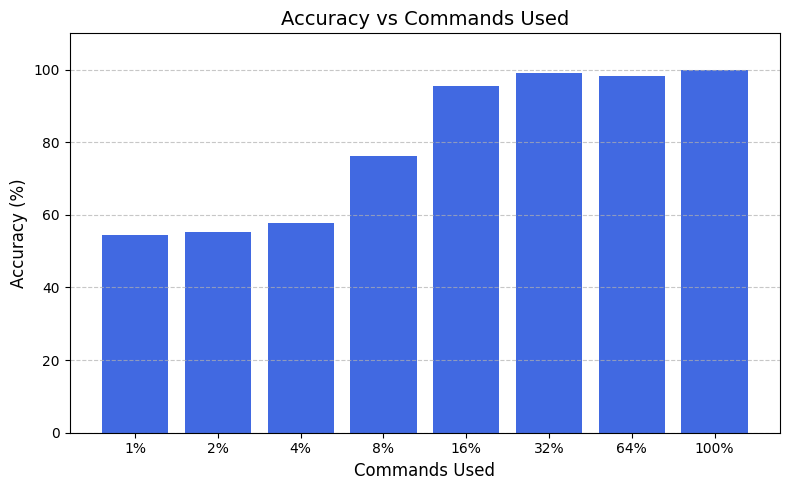

In [8]:
N = 8
epochs = 10
Y = []

for i in range(N):
    train_path, test_path = paths[i]

    dataset_train = SCANDataset(
        file_path=train_path,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataset_test = SCANDataset(
        file_path=test_path,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    model = Transformer(
        src_vocab_size=len(src_vocab),
        tgt_vocab_size=len(tgt_vocab),
        src_pad_idx=src_vocab['<PAD>'],
        tgt_pad_idx=tgt_vocab['<PAD>'],
        emb_dim=EMB_DIM,
        num_layers=N_LAYERS,
        num_heads=N_HEADS,
        forward_dim=FORWARD_DIM,
        dropout=DROPOUT,
        max_len=MAX_LEN,
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])

    train_loop(model, optimizer, criterion, dataloader_train, epochs)

    token_accuracy, seq_accuracy = eval_loop(model, dataloader_test)

    print(f'Token-level accuracy: {token_accuracy}, Sequence-level accuracy: {seq_accuracy}')

    Y.append(token_accuracy * 100)

X = ['1%', '2%', '4%', '8%', '16%', '32%', '64%', '100%']

plt.figure(figsize=(8, 5))
plt.bar(X, Y, color='royalblue')
plt.xlabel('Commands Used', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 110)
plt.title('Accuracy vs Commands Used', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()